In [78]:
import numpy as np
import pandas as pd
import timeit
import time
import json
import re
import itertools
import matplotlib.pyplot as plt
#import cupy
import string
from sklearn import linear_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

In [2]:
# import some text, in this case restuarant reviews

yelp_business_datapath = '/home/matt_valley/PycharmProjects/insight_2020a_project/Resto_names/yelp_dataset/review.json'

num_entries = 1000
users = []
with open(yelp_business_datapath) as fl:
    for i, line in enumerate(fl):
        users.append(json.loads(line))
        if i+1 >= num_entries:
            break
df = pd.DataFrame(users)

In [3]:
# load spacy model

model = 'en_core_web_sm' # for testing on laptop
#model = 'en_core_web_lg'
#model = 'en_vectors_web_lg' # many more words
nlp = spacy.load(model)
#sentencizer = nlp.create_pipe("sentencizer")
#nlp.add_pipe(sentencizer)

In [4]:
# rudimentary text chunking pipeline

all_sentences = []
all_sentence_entities = []
all_tokens = []
for r, review in enumerate(df.text):
    doc = nlp(review)
    tokens = [token.text for token in doc]
    sentences = [sent for sent in doc.sents]
    sentence_entities = [ent.text for ent in doc.ents]
    all_tokens.append(tokens)
    all_sentences.append(sentences)
    all_sentence_entities.append(sentence_entities)
    
df['tokens'] = all_tokens
df['sentences'] = all_sentences
df['entities'] = all_sentence_entities

In [32]:
'''
# do it another way, from https://gist.github.com/narulkargunjan/5319ed32d092d1fa7b52fec3a774e0e5
columns=['text',
           'log_probability',
           'stop?',
           'punctuation?',
           'whitespace?',
           'number?',
           'out of vocab.?']
token_df = pd.DataFrame(columns=columns)
    
for r, review in enumerate(df.text):
    doc = nlp(review)
    token_attributes = [(token.orth_,
                         token.prob,
                         token.is_stop,
                         token.is_punct,
                         token.is_space,
                         token.like_num,
                         token.is_oov)
                        for token in doc]
    temp_df = pd.DataFrame(token_attributes, columns=columns)
    token_df = token_df.append(temp_df)
'''


In [19]:
# data must be a list of strings
data = [sent for sent in df.text]

n_samples = 2000
n_features = 1000
n_components = 20
n_top_words = 10

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time.time()
tf = tf_vectorizer.fit_transform(data)
tfidf = tfidf_vectorizer.fit_transform(data)
print("done in %0.3fs." % (time.time() - t0))



done in 0.173s.


In [20]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [25]:
#Do LDA

lda = LatentDirichletAllocation(n_components=n_components,random_state=0, verbose=1, max_iter=20)
lda.fit(tfidf)

tf_feature_names = tf_vectorizer.get_feature_names()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

print(tf_feature_names)
print(tfidf_feature_names)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20
['00', '10', '100', '11', '12', '14', '15', '20', '25', '30', '40', '45', '50', '99', 'able', 'absolutely', 'ac', 'actually', 'add', 'added', 'additional', 'admit', 'affordable', 'afternoon', 'ago', 'ahead', 'air', 'airport', 'amazing', 'ambiance', 'answer', 'anymore', 'apparently', 'appetizer', 'appetizers', 'apple', 'appointment', 'appreciated', 'area', 'aren', 'arrive', 'arrived', 'asian', 'ask', 'asked

In [26]:
print_top_words(lda, tfidf_feature_names, n_top_words)

Topic #0: facility la clear tried et joint boba cut month rate
Topic #1: valley indian healthy tv sauces games entrees craving especially location
Topic #2: salon crepe nail nails kabob class english chinese area bonus
Topic #3: piano unless multiple near choices pizza soup open lots house
Topic #4: venue attitude overpriced ship asian seat basically steak fried wow
Topic #5: great miss ask flavored online cheap prepared service needs car
Topic #6: sushi crab seafood buffet brunch breakfast crispy rolls pricing awful
Topic #7: cake tea ice cream used chocolate bowl apparently cold looks
Topic #8: food good place great really chicken like just service delicious
Topic #9: team daily stick curry spend range honey soda 14 spectacular
Topic #10: email pizza cheesy staff napkins burger awesome layout pricing serve
Topic #11: hair massage goes relaxing foot picture filled matter boyfriend particular
Topic #12: sugar eggplant love cocktails class bartender fabulous desert morning pie
Topic #13

In [47]:
# SENTIMENT ANALYSIS

# see: From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015 
# http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences



# Load our dataset
df_yelp = pd.read_table('~/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/sentiment_labelled_sentences/yelp_labelled.txt')
df_imdb = pd.read_table('~/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/sentiment_labelled_sentences/imdb_labelled.txt')
df_amz = pd.read_table('~/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/sentiment_labelled_sentences/amazon_cells_labelled.txt')

frames = [df_yelp,df_imdb,df_amz]

for colname in frames:
    colname.columns = ["Message","Target"]
    
# Assign a Key to Make it Easier
keys = ['Yelp','IMDB','Amazon']
sentiment_df = pd.concat(frames,keys=keys)

print(sentiment_df.shape)
sentiment_df.head()

(2745, 2)


Message  Target
Yelp 0                                 Crust is not good.       0
     1          Not tasty and the texture was just nasty.       0
     2  Stopped by during the late May bank holiday of...       1
     3  The selection on the menu was great and so wer...       1
     4     Now I am getting angry and I want my damn pho.       0

In [48]:
sentiment_model = spacy.load(model)
stopwords = list(STOP_WORDS)
punctuations = string.punctuation
parser = English()

In [44]:
# from https://github.com/Jcharis/Natural-Language-Processing-Tutorials/blob/master/Text%20Classification%20With%20Machine%20Learning,SpaCy,Sklearn(Sentiment%20Analysis)/Text%20Classification%20&%20Sentiment%20Analysis%20with%20SpaCy,Sklearn.ipynb

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]
    return mytokens

tokens = [spacy_tokenizer(s[0].text) for s in df.sentences]
    

In [61]:
#Custom transformer using spaCy 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic function to clean the text 
def clean_text(text):     
    return text.strip().lower()


# Vectorization
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) 
classifier = LinearSVC()


# Features and Labels
X = sentiment_df['Message']
ylabels = sentiment_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=42)

# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

In [62]:
# Fit our data
pipe.fit(X_train,y_train)


Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f83af95d790>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7f83a5b603b0>,
                                 vocabulary=None)),
                ('classifier',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                

In [63]:
# Predicting with a test dataset
sample_prediction = pipe.predict(X_test)

In [65]:
# Accuracy
print("Test accuracy: ",pipe.score(X_test,y_test))
print("Train accuracy: ",pipe.score(X_train,y_train))

Test accuracy:  0.8069216757741348
Train accuracy:  0.9895264116575592


In [7]:
# VECTORIZE SENTENCES AND SENT FRAGMENTS

model = 'en_core_web_sm' # for testing on laptop
#model = 'en_core_web_lg'
#model = 'en_core_web_lg' # many more words
nlp = spacy.load(model, disable=["parser"])
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

In [8]:
print(nlp.pipe_names)

['tagger', 'ner', 'sentencizer']


In [13]:
def split_sentences(doc, pos_filter=['NOUN', 'VERB', 'ADV']):
    # take input document and vectorize in context, and clean
    # for topic model return nouns and verbs
    # for sentiment return  adverbs    
    # return list of lists, corresponding to the filtered entities within each sentences
    sent_text = []
    all_tokens = []
    all_token_vectors = []
    for span in doc.sents:
        span_doc = span.as_doc(copy_user_data=True)
        sent_text.append(span_doc.text)
        tokens = [t for i,t in enumerate(span_doc) if t.pos_ in pos_filter]
        all_tokens.append(tokens)
        token_vectors = [t.vector for i,t in enumerate(span_doc) if t.pos_ in pos_filter]
        all_token_vectors.append(token_vectors)
    return sent_text, all_tokens, all_token_vectors

In [47]:
print(len(df.text))

1000


In [68]:
sentence_df = pd.DataFrame(columns=['sentences','tokens','token_vectors'])
for r, review in enumerate(df.text):
    doc = nlp(review)
    sentences, tokens, token_vectors = split_sentences(doc) 
    entry_df = pd.DataFrame()
    entry_df['sentences'] = sentences
    entry_df['tokens'] = tokens
    entry_df['token_vectors'] = token_vectors
    sentence_df = pd.concat([sentence_df, entry_df], axis=0)
    #sentence_df.join(entry_df)

In [76]:
mat = np.array(list(itertools.chain.from_iterable(sentence_df.token_vectors)))
mat.shape


(47232, 96)

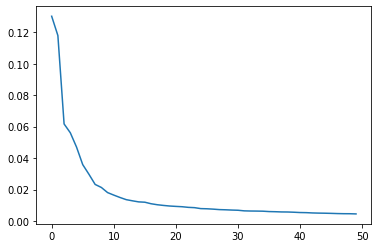

In [92]:
pca = PCA(n_components=50)
pca.fit(mat)
plt.plot(pca.explained_variance_ratio_)

In [61]:
mean_vecs = []
for s in token_vectors:
    vec = np.empty([96])
    for s_vec in s: # in each sentence
        vec = np.vstack((vec,s_vec))
        mvec = np.mean(vec, axis=0)
    mean_vecs.append(mvec)

mean_vecs = np.array(mean_vecs)
print(mean_vecs.shape)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [32]:
vec

array([[ 2.66351597e-03,  2.61099718e-04,  2.05655426e-01,
         1.24012484e-11,  9.03863068e+01,  8.61902138e-04,
         3.65641190e-02,  2.03120408e-06,  5.56265333e+01,
         2.57112048e-02,  9.42432761e-12,  2.29605029e-05,
         1.29068009e-08,  3.04721022e+00,  5.30084154e-09,
         9.12991332e+02,  2.56850596e-10,  5.95673100e-02,
         3.81052077e-01,  3.57896313e-02,  3.45892943e-07,
         2.48507373e+03,  3.73675442e-03,  1.02039819e-04,
         1.07310023e-02,  2.28007460e+00,  3.65018385e+01,
         3.91556692e+00,  1.49919566e-09,  3.82102793e-03,
         1.24066725e-01,  8.02262426e-01,  1.66032549e-10,
         1.06356714e+03,  2.74782243e-04,  4.91377648e-05,
         2.33812675e+01,  4.93783414e-01,  1.17585969e+00,
         4.85569534e+01,  7.69502667e-02,  5.80360317e+00,
         1.02580655e-04,  1.35581704e-05,  5.02689479e-01,
         1.13041326e-01,  1.35860276e+00,  1.08825333e+02,
         1.30079948e-04,  7.01908333e-07,  3.23985159e-0